# Análisis de Series de Tiempo II

### Entrenamiento y pronóstico con la serie suavizada con filtro de Kalman.

---

Entrenamos 4 modelos para predecir el delta de temperatura (LST).

- Holt-Winters (baseline)
- LSTM
- GRU
- Transformer

En todos los casos se utilizaron los mismos hiperparámetros que para el entrenamiento con la serie sin suavizar.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from colores import colores

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
import os
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


Los datos se encuentran en la carpeta csv:
- ts_imputado_*: las LST de los 5 años, para pino y para estepa, con los faltantes ya imputados por diferentes métodos.

In [62]:
# Temperaturas diurnas (diarias)
# archivo = "csv/ts_imputado_bilstm.csv" # imputaciones con BiLSTM
# 
archivo = "csv/ts_imputado_bilstm_k.csv"   # imputaciones con BiLSTM + filtro de Kalman

df_d_diaria = pd.read_csv(archivo, parse_dates=["fecha"],
    dtype={"pino": "float64",
           "estepa": "float64",
           "mes": "int64",
           "delta": "float64"
          })

df_d_diaria.head(10)

,fecha,estepa,pino,mes,delta
0,2020-01-01,25.248988,22.406258,1,2.842729
1,2020-01-02,28.261892,24.635487,1,3.626405
2,2020-01-03,29.688001,25.523245,1,4.164756
3,2020-01-04,30.002555,25.258818,1,4.743737
4,2020-01-05,28.553355,23.756093,1,4.797261
5,2020-01-06,27.876731,23.415669,1,4.461062
6,2020-01-07,27.767456,23.207273,1,4.560183
7,2020-01-08,28.093476,23.735724,1,4.357751
8,2020-01-09,28.839865,24.335628,1,4.504237
9,2020-01-10,30.050188,25.055875,1,4.994313


---
## Preparación de datos para entrenamiento

Se entrenarán modelos para estimar el delta de temperatura diarias diurna

In [63]:
df_serie = df_d_diaria[['fecha','delta']] # datos diarios sin gaps

df_serie = df_serie.set_index('fecha')
df_serie.index = pd.to_datetime(df_serie.index)
df_serie.head()

,delta
fecha,
2020-01-01,2.842729
2020-01-02,3.626405
2020-01-03,4.164756
2020-01-04,4.743737
2020-01-05,4.797261


#### Split train y test

In [64]:
train_size = int(len(df_serie) * 0.8)  # 80 % entrenamiento, 20 % test
train_size # puntos

1461

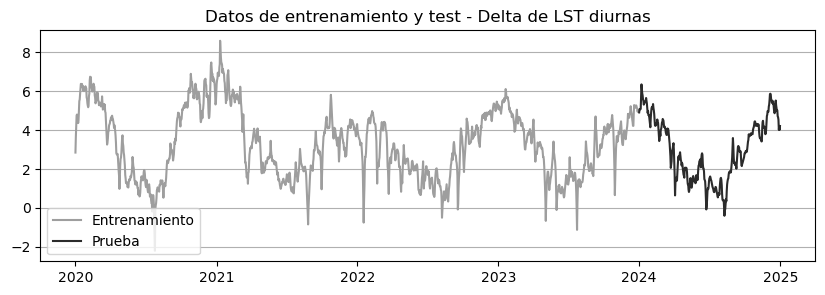

In [65]:
train = df_serie['delta'].iloc[:train_size]
test = df_serie['delta'].iloc[train_size:]

plt.figure(figsize=(10, 3))
plt.plot(train, label='Entrenamiento', color=colores['train'])
plt.plot(test, label='Prueba', color=colores['test'])
plt.legend(loc='lower left')

plt.grid(axis='y')
plt.title('Datos de entrenamiento y test - Delta de LST diurnas')
plt.show()

In [66]:
# Cuántos datos hay por año?
train.groupby(train.index.year).count()

fecha
2020    366
2021    365
2022    365
2023    365
Name: delta, dtype: int64

In [67]:
test.groupby(test.index.year).count()

fecha
2024    366
Name: delta, dtype: int64

#### Split

In [68]:
# función para crear secuencias
def create_sequences(data, seq_length, target_idx=0):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)


In [69]:
# Escala
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_serie['delta'].values.reshape(-1,1))

# Crea secuencias sobre toda la serie
seq_length = 182 # medio año
X, y = create_sequences(data_scaled, seq_length=seq_length)

test_points = 366  # 1 año

# convertir puntos a número de secuencias
test_sequences = test_points
train_sequences = len(X) - test_sequences

X_train, y_train = X[:train_sequences], y[:train_sequences]
X_test,  y_test  = X[train_sequences:], y[train_sequences:]

In [70]:
# Índices y variables auxiliares para los plots

# cantidad de secuencias del train
train_size_sec = len(X_train)

# posición real en la serie original
train_end_real = train_size_sec + seq_length  # 1279 + 182 = 1461
offset = train_end_real

datos_train = df_serie['delta'].iloc[:offset]
datos_test = df_serie['delta'].iloc[offset:]

index_train = df_serie.index[:offset]
index_test = df_serie.index[offset:]
index_forecast = df_serie.index[offset : offset + len(X_test)]


---
## Entrenamiento

In [71]:
def guardar_estadisticas( modelo, mae, mse, rmse, imprimir=True):
    if modelo in df_resultados['Modelo'].values:
        df_resultados.loc[df_resultados['Modelo'] == modelo, [ 'MAE', 'MSE', 'RMSE']] = [mae, mse, rmse]
    else:
        df_resultados.loc[len(df_resultados)] = [modelo, mae, mse, rmse]
    if imprimir:
        print(f"modelo {modelo}")
        print(f"MAE  : {mae:.4f}")
        print(f"MSE  : {mse:.4f}")
        print(f"RMSE : {rmse:.4f}")

# Dataframe para guardar los resultados
df_resultados = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'RMSE'])

### Modelo baseline Holt-Winters

El modelo Holt-Winters es una extensión del suavizado exponencial que permite modelar series temporales con tendencia y estacionalidad. Este modelo no requiere que la serie sea estacionaria, ya que incorpora explícitamente componentes de nivel, tendencia y estacionalidad.

#### Resultados de Optuna para Holt-Winters:

- Mejores params: {'trend': 'add', 'seasonal': 'add', 'use_boxcox': False, 'alpha': 0.05250488218458049, 'beta': 0.24427161109037507, 'gamma': 0.3076931343436633, 'phi': 0.9620148907784558, 'damped_trend': True}

In [72]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

In [73]:
# Ajusta el modelo Holt-Winters
model_hw = ExponentialSmoothing(
    datos_train,
    trend='add',
    seasonal= 'add',
    seasonal_periods=365,
    use_boxcox= False,
    damped_trend= True,
    initialization_method='heuristic'
)

alpha= 0.05250488218458049
beta = 0.24427161109037507
gamma= 0.3076931343436633
phi= 0.9620148907784558
    
fit = model_hw.fit(
    smoothing_level=alpha,
    smoothing_slope=beta,
    smoothing_seasonal=gamma,
    damping_slope=phi,
    optimized=False 
)

# Genera el pronóstico
forecast_hw = fit.forecast(len(datos_test))

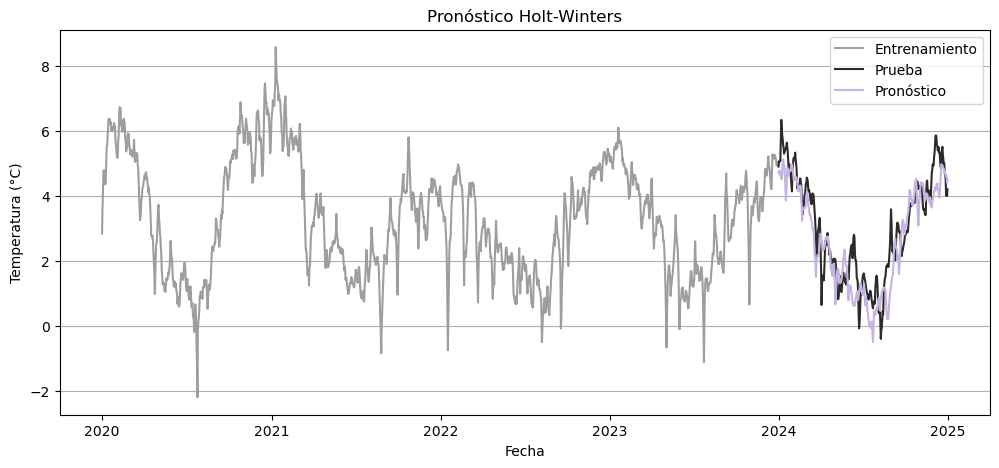

In [74]:
# Visualizar resultados
plt.figure(figsize=(12, 5))

plt.plot(train.index, df_serie['delta'].iloc[:train_size], label='Entrenamiento', color=colores['train'])
plt.plot(test.index, df_serie['delta'].iloc[train_size:], label='Prueba', color=colores['test'])
plt.plot(test.index, forecast_hw, label='Pronóstico', color=colores['otro'])
plt.title('Pronóstico Holt-Winters')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()

In [75]:
mae_hw = mean_absolute_error(test,forecast_hw)
mse_hw = mean_squared_error(test,forecast_hw)
rmse_hw = np.sqrt(mean_squared_error(test,forecast_hw))

guardar_estadisticas('BASELINE', mae_hw, mse_hw, rmse_hw)

modelo BASELINE
MAE  : 0.6203
MSE  : 0.6056
RMSE : 0.7782


### a) LSTM

El modelo LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente diseñada para capturar dependencias de largo plazo en series temporales. LSTM no requiere que la serie sea estacionaria y puede aprender patrones complejos no lineales en los datos, incluyendo tendencias, estacionalidades y efectos de interacciones pasadas.

#### Resultados de Optuna para LSTM:

- Mejores params: {'units1': 32, 'units2': 24, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'lr': 0.0011982448134112169, 'batch_size': 64, 'n_layers': 1}

In [76]:
# Modelo LSTM (1 capa)
    
set_seed(42)
input_shape = (seq_length, 1)
model = Sequential([
    Input(shape=input_shape),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.30000000000000004),
    Dense(1)
])

# Compila el modelo
model.compile(optimizer=Adam(learning_rate=0.0011982448134112169), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Entrena el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stopping],
    verbose=1) 


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.2302 - val_loss: 0.0735
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1212 - val_loss: 0.0382
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0549 - val_loss: 0.0247
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0312 - val_loss: 0.0237
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0291 - val_loss: 0.0224
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0271 - val_loss: 0.0216
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0249 - val_loss: 0.0208
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0224 - val_loss: 0.0203
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0228 - val_loss: 0.0196
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0214 - val_loss: 0.0190
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0204 - val_loss: 0.0184
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

In [77]:
# Generar pronósticos
set_seed(42)
forecast_scaled = model.predict(X_test)
forecast_lstm = scaler.inverse_transform(forecast_scaled)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


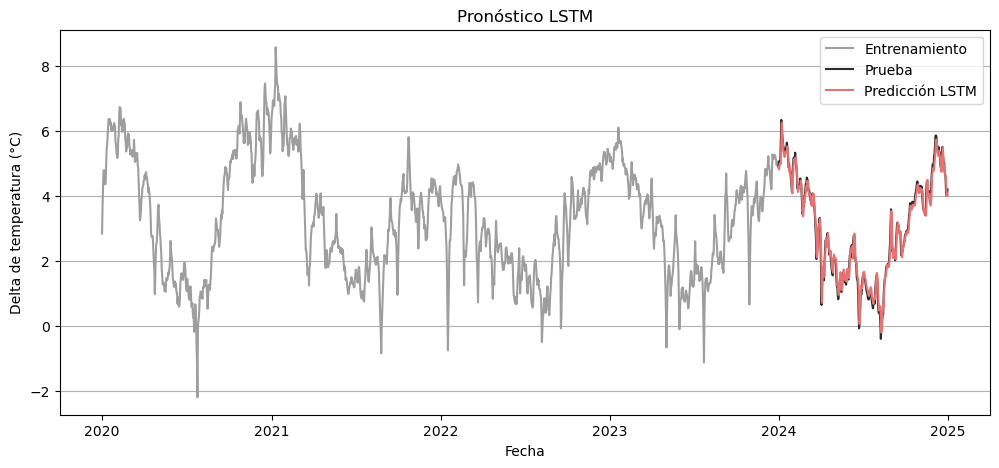

In [78]:
# Visualizar resultados

plt.figure(figsize=(12, 5))
plt.plot(index_train, datos_train, label="Entrenamiento", color=colores['train'])
plt.plot(index_test, datos_test, label="Prueba", color=colores['test'])
plt.plot(index_forecast, forecast_lstm, label="Predicción LSTM", color=colores['LSTM'])

plt.title('Pronóstico LSTM')
plt.xlabel('Fecha')
plt.ylabel('Delta de temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()


In [79]:
# Calcular métricas de error

mae = mean_absolute_error(datos_test, forecast_lstm)
mse = mean_squared_error(datos_test, forecast_lstm)
rmse = np.sqrt(mse)

guardar_estadisticas('LSTM',mae, mse, rmse)

modelo LSTM
MAE  : 0.1712
MSE  : 0.0528
RMSE : 0.2299


### b) GRU

El modelo GRU (Gated Recurrent Unit) es una variante simplificada y más eficiente de la LSTM, también diseñada para modelar dependencias de largo plazo en series temporales. Utiliza solo dos compuertas (update y reset) en lugar de tres, lo que reduce significativamente el número de parámetros y acelera tanto el entrenamiento como la inferencia, manteniendo un rendimiento comparable o incluso superior en muchas tareas. Al igual que la LSTM, no necesita estacionariedad y aprende automáticamente tendencias, ciclos y relaciones no lineales complejas entre eventos pasados y futuros.

#### Resultados de Optuna para GRU:

- Mejores params: {'units1': 64, 'units2': 48, 'dropout1': 0.4, 'dropout2': 0.2, 'lr': 0.0009420655442125198, 'batch_size': 16, 'n_layers': 1}

In [80]:
# Modelo GRU
set_seed(42)
input_shape = (seq_length, 1)
model = Sequential([
    Input(shape=input_shape),
    GRU(64, activation='tanh', return_sequences=False),
    Dropout(0.4),
    Dense(1)
])

# Compila el modelo
model.compile(optimizer=Adam(learning_rate=0.0009420655442125198), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Entrena el modelo
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stopping],
    verbose=1) 


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.1087 - val_loss: 0.0120
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0142 - val_loss: 0.0109
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0127 - val_loss: 0.0098
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0116 - val_loss: 0.0088
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0077 - val_loss: 0.0065
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0071 - val_loss: 0.0056
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step

In [81]:
# Generar pronósticos
set_seed(42)
forecast_scaled = model.predict(X_test)
forecast_gru = scaler.inverse_transform(forecast_scaled)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


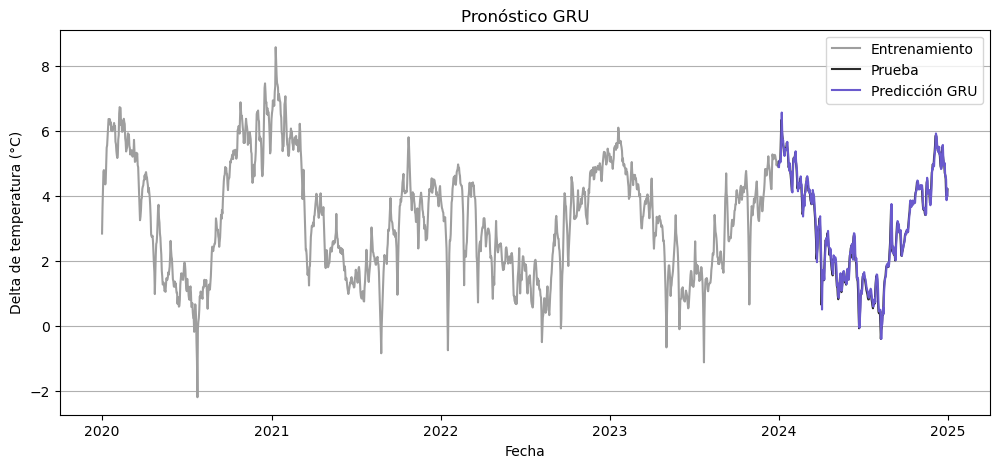

In [82]:
# Visualizar resultados

plt.figure(figsize=(12, 5))
plt.plot(index_train, datos_train, label="Entrenamiento", color=colores['train'])
plt.plot(index_test, datos_test, label="Prueba", color=colores['test'])
plt.plot(index_forecast, forecast_gru, label="Predicción GRU", color=colores['GRU'])

plt.title('Pronóstico GRU')
plt.xlabel('Fecha')
plt.ylabel('Delta de temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()


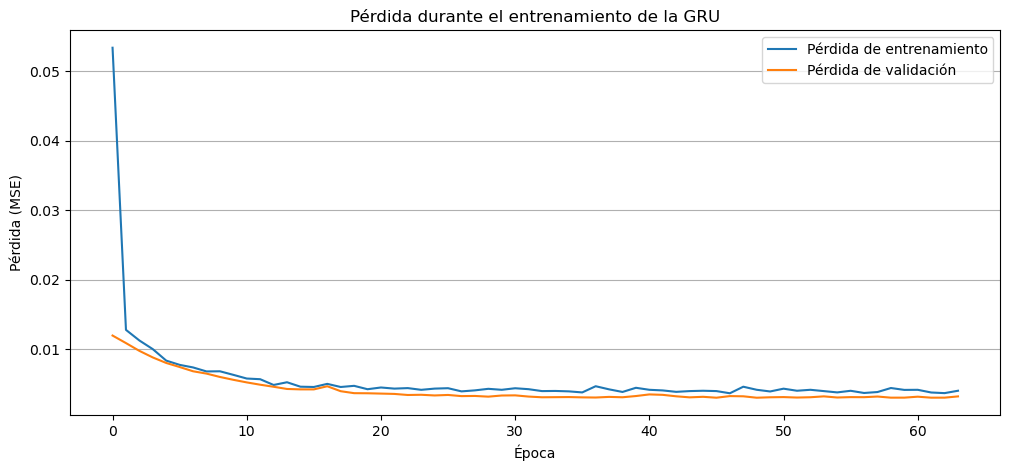

In [83]:
# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento de la GRU')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(axis='y')
plt.show()


In [84]:
# Calcular métricas de error
mae = mean_absolute_error(datos_test, forecast_gru)
mse = mean_squared_error(datos_test, forecast_gru)
rmse = np.sqrt(mse)

guardar_estadisticas('GRU',mae, mse, rmse)

modelo GRU
MAE  : 0.1492
MSE  : 0.0416
RMSE : 0.2041


### c) Transformer

Los Transformers representan un cambio fundamental respecto LSTM y GRU en series temporales, porque eliminan la recurrencia y usan atención para capturar dependencias entre cualquier par de puntos en la secuencia, sin importar la distancia temporal. Son especialmente potentes para detectar patrones complejos, interacciones no locales y relaciones de múltiples escalas temporales (diarias, semanales, anuales) en una sola pasada.

#### Resultados de Optuna para Transformer:

- Mejores params: {'d_model': 80, 'n_heads': 4, 'n_layers': 3, 'ff_dim': 224, 'dropout': 0.15000000000000002, 'final_dropout': 0.4, 'lr': 0.0020244831112923374, 'batch_size': 32}

In [94]:
# Transformer
set_seed(42)

class PositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        
        # Crea matriz de positional encoding (sinusoide fija)
        pe = np.zeros((seq_len, d_model))
        position = np.arange(0, seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]  # (1, seq_len, d_model)
        self.pe = tf.constant(pe, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pe[:, :tf.shape(inputs)[1], :]


def build_transformer(d_model=64, n_heads=4, n_layers=2, ff_dim=128, dropout=0.1, final_dropout=0.2):

    seq_length = X_train.shape[1]
    n_features = X_train.shape[2]

    inputs = Input(shape=(seq_length, n_features))
    
    # 1. Proyección lineal a d_model
    x = layers.Dense(d_model)(inputs)
    
    # 2. POSITIONAL ENCODING
    x = PositionalEncoding(seq_length, d_model)(x)
    
    # 3. Bloques Transformer
    for _ in range(n_layers):
        # Multi-Head Self Attention
        attn_output = layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=d_model//n_heads, dropout=dropout
        )(x, x)
        attn_output = layers.Dropout(dropout)(attn_output)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed Forward
        ff = layers.Dense(ff_dim, activation='relu')(x1)
        ff = layers.Dense(d_model)(ff)
        ff = layers.Dropout(dropout)(ff)
        x = layers.LayerNormalization(epsilon=1e-6)(x1 + ff)

        
    # 4. Salida
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(final_dropout)(x)
    outputs = layers.Dense(1)(x)
    
    model = Model(inputs, outputs)
    return model
    
model = build_transformer(d_model=80, n_heads=4, n_layers=3, ff_dim=224,
                          dropout=0.15000000000000002, final_dropout=0.4)

# Compila el modelo
model.compile(optimizer=Adam(learning_rate=0.0020244831112923374),
              loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),

# Entrena el modelo
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=False, 
                    epochs=100, batch_size=32, callbacks=early_stopping,verbose=1)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 460ms/step - loss: 5.3155 - mae: 1.6297 - val_loss: 0.0680 - val_mae: 0.2269
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - loss: 0.3787 - mae: 0.4929 - val_loss: 0.2716 - val_mae: 0.4529
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step - loss: 0.3124 - mae: 0.4641 - val_loss: 0.1912 - val_mae: 0.3669
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - loss: 0.2909 - mae: 0.4656 - val_loss: 0.2007 - val_mae: 0.3778
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 443ms/step - loss: 0.2531 - mae: 0.4318 - val_loss: 0.1885 - val_mae: 0.3645
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - loss: 0.2302 - mae: 0.4098 - val_loss: 0.1899 - val_mae: 0.3670
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - loss: 0.2288 - mae: 0.4101 - val_loss: 0.1807 - val_mae: 0.3596
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 471ms/step - loss: 0.2068 - mae: 0.3934 - val_loss: 0.2015 - val_mae: 0.4030
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1

In [95]:
# Generar pronósticos
set_seed(42)
forecast_scaled = model.predict(X_test)
forecast_transf = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).ravel()


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step


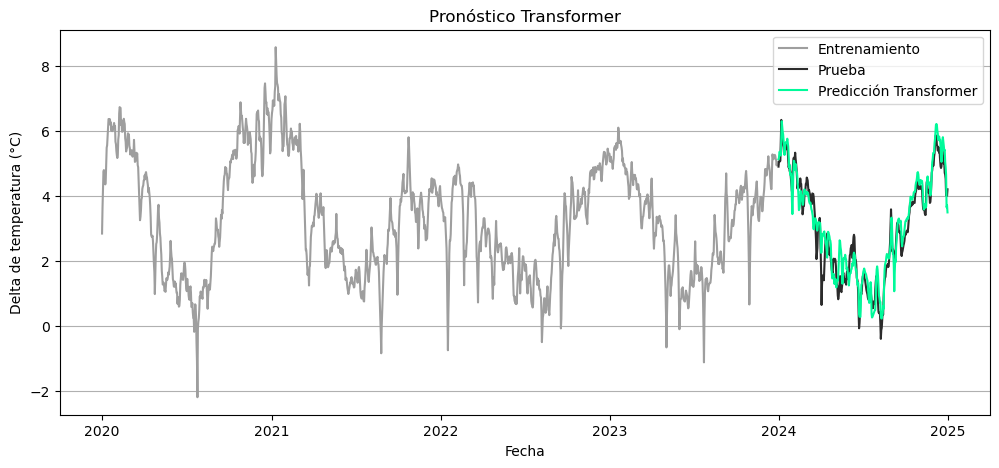

In [96]:
# Visualizar resultados

plt.figure(figsize=(12, 5))
plt.plot(index_train, datos_train, label="Entrenamiento", color=colores['train'])
plt.plot(index_test, datos_test, label="Prueba", color=colores['test'])
plt.plot(index_forecast, forecast_transf, label="Predicción Transformer", color=colores['TRANSFRMR'])

plt.title('Pronóstico Transformer')
plt.xlabel('Fecha')
plt.ylabel('Delta de temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()


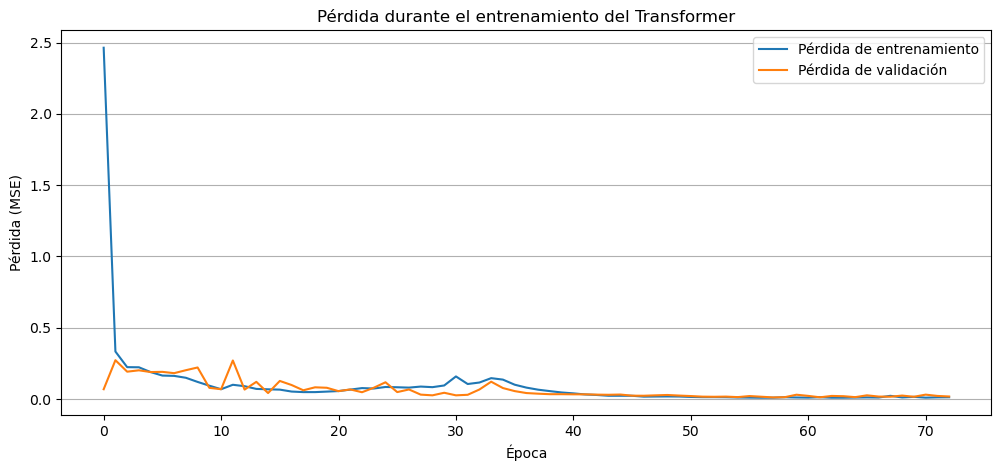

In [97]:
# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento del Transformer')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(axis='y')
plt.show()

In [98]:
# Calcular métricas de error

mae = mean_absolute_error(datos_test, forecast_transf)
mse = mean_squared_error(datos_test, forecast_transf)
rmse = np.sqrt(mse)

guardar_estadisticas('TRANSFORMER',mae, mse, rmse)

modelo TRANSFORMER
MAE  : 0.3611
MSE  : 0.2078
RMSE : 0.4558


### Pronósticos (para todos los modelos)

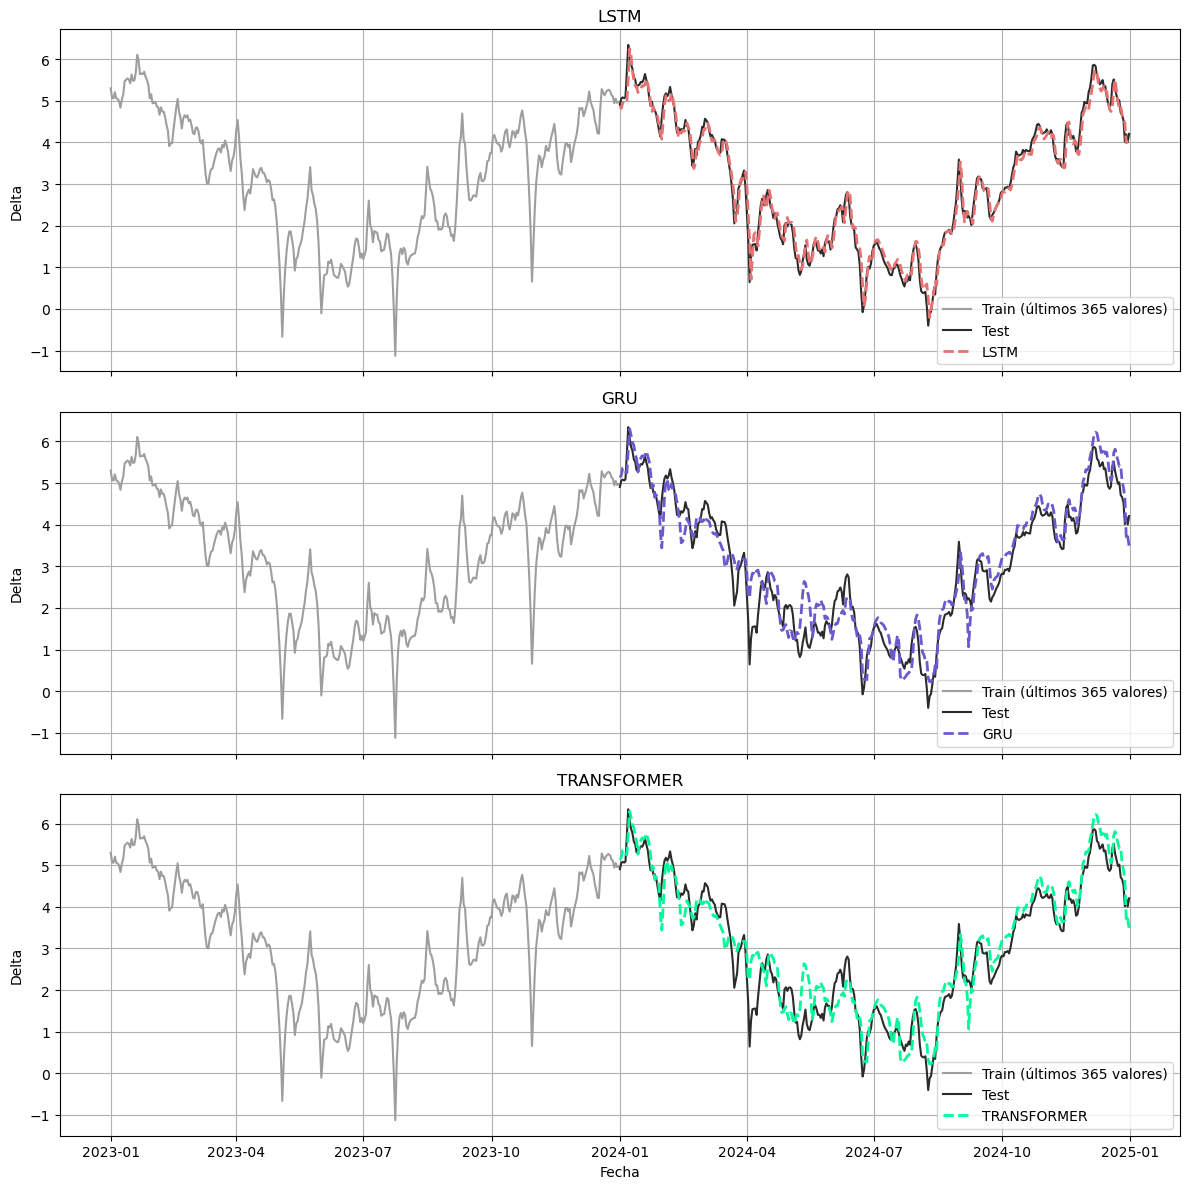

In [99]:
# Número de puntos históricos a mostrar
n_last = 365 # un año de datos
train_recent = train[-n_last:]

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

# Lista de pronósticos y nombres
forecasts = [forecast_lstm, forecast_transf, forecast_transf]
names = ['LSTM', 'GRU', 'TRANSFORMER']
colors = [colores['LSTM'], colores['GRU'], colores['TRANSFRMR']]

for ax, forecast, name, color in zip(axes, forecasts, names, colors):
    # Plot train reciente
    ax.plot(train_recent.index, train_recent.values, label=f'Train (últimos {n_last} valores)', color=colores['train'])
    # Plot test
    ax.plot(test.index, test.values, label='Test', color=colores['test'])
    # Plot pronóstico
    ax.plot(test.index, forecast, label=name, linestyle='--', lw=2, color=color)

    ax.set_title(name)
    ax.set_ylabel('Delta')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()


### Resultados

In [100]:
resultados = df_resultados.copy()
resultados.set_index('Modelo', inplace=True)
resultados

,MAE,MSE,RMSE,Mejora vs Baseline (MAE),Mejora vs Baseline (RMSE)
Modelo,,,,,
BASELINE,0.620336,0.605579,0.778190,0.000000,0.000000
LSTM,0.171193,0.052834,0.229857,-72.403217,-70.462622
GRU,0.149229,0.041645,0.204070,-75.943928,-73.776331
TRANSFORMER,0.361078,0.207799,0.455849,54.741647,47.404417


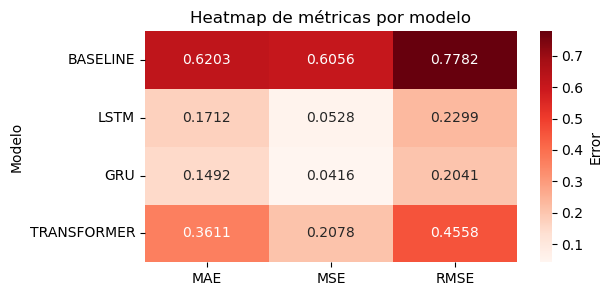

In [105]:
plt.figure(figsize=(6,3))
# sns.heatmap(resultados[['MAE','MSE','RMSE']].drop(index="BASELINE"), annot=True, fmt=".4f", cmap='Reds', cbar_kws={'label': 'Error'})
sns.heatmap(resultados[['MAE','MSE','RMSE']], annot=True, fmt=".4f", cmap='Reds', cbar_kws={'label': 'Error'})
plt.title('Heatmap de métricas por modelo')
plt.show()


Para confirmar si las métricas son razonables, las comparamos en relación al modelo baseline.

In [102]:
mae_seasonal = resultados.loc['BASELINE']['MAE']
rmse_seasonal = resultados.loc['BASELINE']['RMSE']

df_resultados['Mejora vs Baseline (MAE)'] = (df_resultados['MAE'] - mae_seasonal) / mae_seasonal * 100
df_resultados['Mejora vs Baseline (RMSE)'] = (df_resultados['RMSE'] - rmse_seasonal) / rmse_seasonal * 100

df_resultados

,Modelo,MAE,MSE,RMSE,Mejora vs Baseline (MAE),Mejora vs Baseline (RMSE)
0,BASELINE,0.620336,0.605579,0.778190,0.000000,0.000000
1,LSTM,0.171193,0.052834,0.229857,-72.403217,-70.462622
2,GRU,0.149229,0.041645,0.204070,-75.943928,-73.776331
3,TRANSFORMER,0.361078,0.207799,0.455849,-41.793204,-41.421820


### Conclusiones

- LSTM y GRU superaron por un margen notable al baseline.
- El Transformer superó al baseline, pero no llegó a ser tan bueno con los otros modelos.

Con respecto al entrenamiento con la serie ruidosa:
- En todos los casos, los resultados fueron ampliamente superadores comparados con los obtenidos en el entrenamiento con la serie original.
- GRU y LSTM fueron los que mejor performaron.